In [ ]:
import torch.optim as optim
import random
import utils_twitter as utils
import time
import math

In [ ]:
device = torch.device('cuda')
print(device)
torch.cuda.get_device_name()

cuda


'NVIDIA A100-SXM4-40GB'

In [ ]:
# Note: it will take about 4min to load everything.
train_data = torch.load('./data_nlp/twitter/train_data.pt')
train_label = torch.load('./data_nlp/twitter/train_label.pt')
test_data = torch.load('./data_nlp/twitter/test_data.pt')
test_label = torch.load('./data_nlp/twitter/test_label.pt')

In [ ]:
n_train = len(train_data)
n_test = len(test_data)

print('Train set:', n_train, 'tweets')
print('Test set:', n_test, 'tweets')

Train set: 1428612 tweets
Test set: 150000 tweets


In [ ]:
def my_scaled_dot_product_attention(Q, K, V):
    # Q has shape (bs, nh, T, d_key)
    # K has shape (bs, nh, T, d_key)
    # V has shape (bs, nh, T, d_val)
    # Y has shape (bs, nh, T, d_val)

    d_key = K.shape[-1]
    A_tilde = Q @ K.transpose(-2,-1) / math.sqrt(d_key)    # (bs, nh, T, T)
    A = F.softmax(A_tilde, dim=-1)                         # (bs, nh, T, T)
    Y = A @ V                                              # (bs, nh, T, d_val)
    return Y

In [ ]:
class EfficientMultiHeadAttention(nn.Module):

    def __init__(self, d, num_heads):
        super().__init__()

        assert d % num_heads == 0
        d_key = d // num_heads
        d_val = d // num_heads

        self.linear_q = nn.Linear(d, num_heads*d_key, bias=False)
        self.linear_k = nn.Linear(d, num_heads*d_key, bias=False)
        self.linear_v = nn.Linear(d, num_heads*d_val, bias=False)
        self.linear_out = nn.Linear(d, d, bias=False)

        self.nh = num_heads
        self.dk = d_key
        self.dv = d_val

    def forward(self, X):
        # X has shape (bs, T, d)
        bs = X.shape[0]
        T = X.shape[1]

        Q = self.linear_q(X)    # (bs, T, nh*dk)
        K = self.linear_k(X)    # (bs, T, nh*dk)
        V = self.linear_v(X)    # (bs, T, nh*dv)

        Q = Q.view(bs, T, self.nh, self.dk)   # (bs, T, nh, dk)
        K = K.view(bs, T, self.nh, self.dk)   # (bs, T, nh, dk)
        V = V.view(bs, T, self.nh, self.dv)   # (bs, T, nh, dv)

        Q = Q.transpose(1,2)    # (bs, nh, T, dk)
        K = K.transpose(1,2)    # (bs, nh, T, dk)
        V = V.transpose(1,2)    # (bs, nh, T, dv)

        Y = my_scaled_dot_product_attention(Q,K,V)    # (bs, nh, T, dv)

        Y = Y.transpose(1,2).contiguous()     # (bs, T, nh, dv)
        Y = Y.view(bs, T, self.nh*self.dv)    # (bs, T, nh*dv)

        Y = self.linear_out(Y)                # (bs, T, d)
        return Y

In [ ]:
class MLP(nn.Module):

    def __init__(self, d):
        super().__init__()
        self.linear_1 = nn.Linear(d, 4*d, bias=False)
        self.linear_2 = nn.Linear(4*d, d, bias=False)

    def forward(self, X):
        # X has shape (bs, T, d)
        Y = self.linear_1(X)        # (bs, T, 4d)
        Y_hat = F.relu(Y)           # (bs, T, 4d)
        Z = self.linear_2(Y_hat)    # (bs, T, d)
        return Z

In [ ]:
class TransformerBlock(nn.Module):

    def __init__(self, d, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(d)
        self.attn = EfficientMultiHeadAttention(d, num_heads)
        self.ln2 = nn.LayerNorm(d)
        self.mlp = MLP(d)

    def forward(self, X):
        # X has shape (bs, T, d)
        X1 = self.ln1(X)
        Y = self.attn(X1)    # (bs, T, d)
        X2 = X + Y           # residual
        X3 = self.ln2(X2)
        Z = self.mlp(X3)     # (bs, T, d)
        output = X2 + Z      # residual
        return output

In [ ]:
class MyTransformer(nn.Module):

    def __init__(self, vocab_size, d, num_heads, num_layers, T):
        super().__init__()

        self.T = T
        self.d = d

        self.word_emb = nn.Embedding(vocab_size, d)
        self.pos_emb = nn.Embedding(T, d)

        blocks = []
        for i in range(num_layers):
            blocks.append(TransformerBlock(d, num_heads))
        self.blocks = nn.ModuleList(blocks)

        self.avg = nn.AvgPool1d(kernel_size=T)
        self.last_linear = nn.Linear(d, 2, bias=False)    # last linear layer to 2 classes

    def forward(self, X):
        # X has shape (bs, T)
        bs = X.shape[0]
        T = X.shape[1]

        pos = torch.arange(T).to(device)        # (T,)
        pos = pos.expand(bs, T)                 # (bs, T)

        Xw = self.word_emb(X)                   # (bs, T, d)
        Xp = self.pos_emb(pos)                  # (bs, T, d)
        X = Xw + Xp                             # (bs, T, d)

        for block in self.blocks:
            X = block(X)                        # (bs, T, d)

        # average over time
        X_avg = X.mean(dim=1)                   # (bs, d)

        scores = self.last_linear(X_avg)
        return scores

In [ ]:
vocab_size = 30002
d = 512
num_heads = 8
num_layers = 4
T = 183

net = MyTransformer(vocab_size, d, num_heads, num_layers, T).to(device)

print(net)
print('')
utils.display_num_param(net)

MyTransformer(
  (word_emb): Embedding(30002, 512)
  (pos_emb): Embedding(183, 512)
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): EfficientMultiHeadAttention(
        (linear_q): Linear(in_features=512, out_features=512, bias=False)
        (linear_k): Linear(in_features=512, out_features=512, bias=False)
        (linear_v): Linear(in_features=512, out_features=512, bias=False)
        (linear_out): Linear(in_features=512, out_features=512, bias=False)
      )
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (linear_1): Linear(in_features=512, out_features=2048, bias=False)
        (linear_2): Linear(in_features=2048, out_features=512, bias=False)
      )
    )
  )
  (avg): AvgPool1d(kernel_size=(183,), stride=(183,), padding=(0,))
  (last_linear): Linear(in_features=512, out_features=2, bias=False)
)

There are 28046848 (28.05 million) parameters in t

In [ ]:
criterion = nn.CrossEntropyLoss()
my_lr = 0.0001
bs = 256

In [ ]:
def eval_on_test_set():

    net.eval()
    running_error = 0
    num_batches = 0

    with torch.no_grad():

        shuffled_indices = torch.randperm(n_test)

        for count in range(0, n_test, bs):

            indices = shuffled_indices[count:count+bs]
            minibatch_data, minibatch_label = utils.make_minibatch(indices, test_data, test_label)

            minibatch_data = minibatch_data.to(device)      # (bs, T)
            minibatch_label = minibatch_label.to(device)    # (bs,)

            scores = net(minibatch_data)
            error = utils.get_error(scores, minibatch_label)

            running_error += error.item()
            num_batches += 1

    total_error = running_error/num_batches
    return total_error

In [ ]:
start = time.time()

num_print1 = 500000 // bs
num_print2 = 1000000 // bs

for epoch in range(5):

    if epoch == 3:
        my_lr = 0.00001

    optimizer = torch.optim.AdamW(net.parameters(), lr=my_lr, weight_decay=0.1, betas=(0.9,0.95))

    net.train()
    running_loss = 0
    running_error = 0
    num_batches = 0

    shuffled_indices = torch.randperm(n_train)

    for count in range(0, n_train, bs):

        optimizer.zero_grad()

        indices = shuffled_indices[count:count+bs]
        minibatch_data, minibatch_label = utils.make_minibatch(indices, train_data, train_label)

        minibatch_data = minibatch_data.to(device)      # (bs, T)
        minibatch_label = minibatch_label.to(device)    # (bs,)

        scores = net(minibatch_data)
        loss = criterion(scores, minibatch_label)

        loss.backward()
        optimizer.step()

        num_batches += 1

        with torch.no_grad():
            running_loss += loss.item()
            error = utils.get_error(scores, minibatch_label)
            running_error += error.item()

        if num_batches == num_print1 or num_batches == num_print2 or count+bs >= n_train:
            total_loss = running_loss/num_batches
            total_error = running_error/num_batches
            test_error = eval_on_test_set()
            elapsed_time = time.time()-start

            frac = (count+bs)/n_train
            if frac > 1:
                frac = 1

            print(' ')
            print('epoch', round(epoch+frac, 2),
                  '\t time=', elapsed_time,
                  '\t lr=', my_lr,
                  '\t loss=', total_loss,
                  '\t train error=', total_error*100, ' percent',
                  '\t test error=', test_error*100, ' percent')

 
epoch 0.35 	 time= 132.6089255809784 	 lr= 0.0001 	 loss= 0.49931127643255596 	 train error= 24.842789938556066  percent 	 test error= 21.528059223813003  percent
 
epoch 0.7 	 time= 262.41212368011475 	 lr= 0.0001 	 loss= 0.46401407835548253 	 train error= 22.408534146185353  percent 	 test error= 19.072365608231607  percent
 
epoch 1 	 time= 376.2020170688629 	 lr= 0.0001 	 loss= 0.44639829274809634 	 train error= 21.266606752856664  percent 	 test error= 18.008790162643066  percent
 
epoch 1.35 	 time= 507.4640073776245 	 lr= 0.0001 	 loss= 0.37938205515550943 	 train error= 17.030689964157705  percent 	 test error= 17.44187286079133  percent
 
epoch 1.7 	 time= 638.9034125804901 	 lr= 0.0001 	 loss= 0.375277995635959 	 train error= 16.835677483358936  percent 	 test error= 16.77821031406064  percent
 
epoch 2 	 time= 752.9991807937622 	 lr= 0.0001 	 loss= 0.37284167874801377 	 train error= 16.68647438410554  percent 	 test error= 16.289240254070165  percent
 
epoch 2.35 	 time= 8

TWEET: thinks its strange . but she would rather be in <unk> still . i miss my family , and i miss <unk>
LABEL: 0


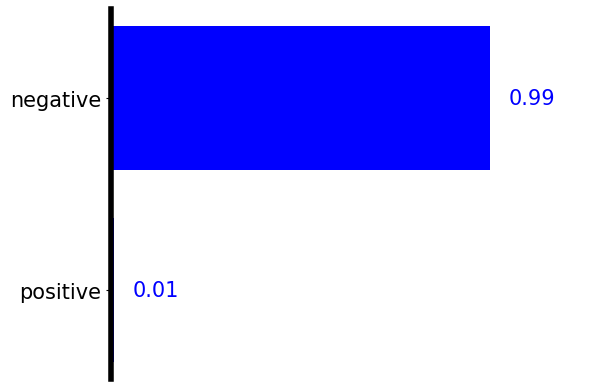

In [ ]:
from random import randint

# choose a tweet at random
idx = randint(0, n_test-1)
tweet_tensor = test_data[idx]
tweet_label = test_label[idx].item()
tweet_text = utils.tensor2text(tweet_tensor)

# make minibatch (bs, T)
indices = torch.tensor([idx])
minibatch_data, minibatch_label = utils.make_minibatch(indices, test_data, test_label)
minibatch_data = minibatch_data.to(device)

net.eval()
with torch.no_grad():
    scores = net(minibatch_data)
    p = F.softmax(scores, dim=1).cpu()

print('TWEET:', tweet_text)
print('LABEL:', tweet_label)
utils.show_prob(p)

TWEET: Ugh, my laptop has been lagging all dayyyy. What's going on???
TENSOR: tensor([    0,    10,   657,   116,   120, 14206,    45,     0,     0,    57,
            0], device='cuda:0')


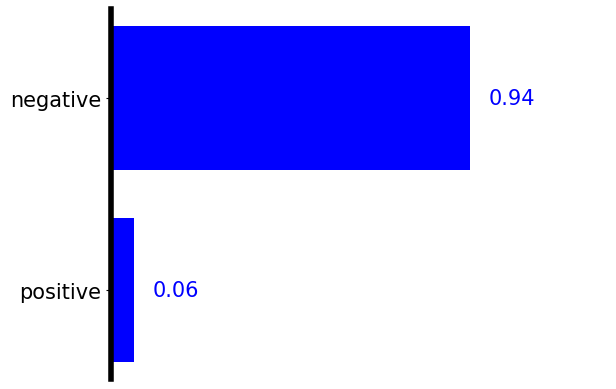

In [ ]:
# example tweet 1
my_tweet_1 = "Ugh, my laptop has been lagging all dayyyy. What's going on???"

x1 = utils.text2tensor(my_tweet_1).to(device)
print('TWEET:', my_tweet_1)
print('TENSOR:', x1)

x1 = x1.view(1,-1)

net.eval()
with torch.no_grad():
    scores = net(x1)
    p = F.softmax(scores, dim=1).cpu()

utils.show_prob(p)

TENSOR: tensor([ 247,  552,  222,    9, 2415], device='cuda:0')
TWEET: omg cry us a river


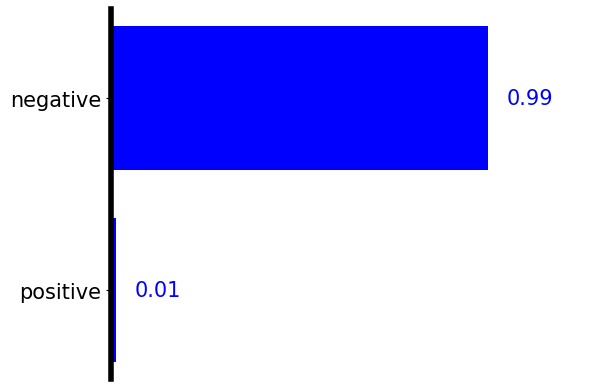

In [ ]:
# example tweet 2
my_tweet_2 = "omg cry us a river"

x2 = utils.text2tensor(my_tweet_2).to(device)
print('TENSOR:', x2)

x2 = x2.view(1,-1)

net.eval()
with torch.no_grad():
    scores = net(x2)
    p = F.softmax(scores, dim=1).cpu()

print('TWEET:', my_tweet_2)
utils.show_prob(p)

TENSOR: tensor([ 236,   35,   10,    0, 9669,   97,   30,    7, 2790,  216,  243, 5259],
       device='cuda:0')
TWEET: Look at my cat! Isn't he just the cutest thing ever :3


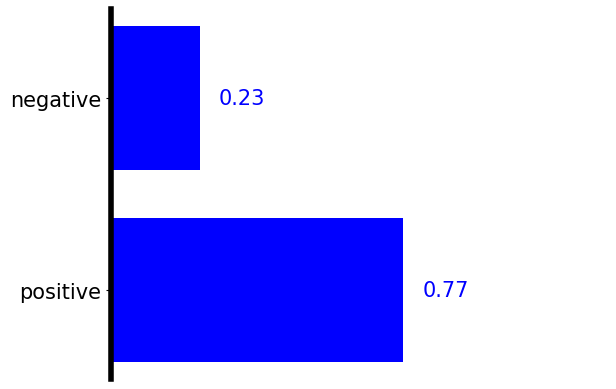

In [ ]:
# example tweet 3
my_tweet_3 = "Look at my cat! Isn't he just the cutest thing ever :3"

x3 = utils.text2tensor(my_tweet_3).to(device)
print('TENSOR:', x3)

x3 = x3.view(1,-1)

net.eval()
with torch.no_grad():
    scores = net(x3)
    p = F.softmax(scores, dim=1).cpu()

print('TWEET:', my_tweet_3)
utils.show_prob(p)

TENSOR: tensor([9814, 2980,   11,  142,   91,  273,    0], device='cuda:0')
TWEET: MERRY CHRISTMAS AND HAPPY NEW YEAR GUYS!!!


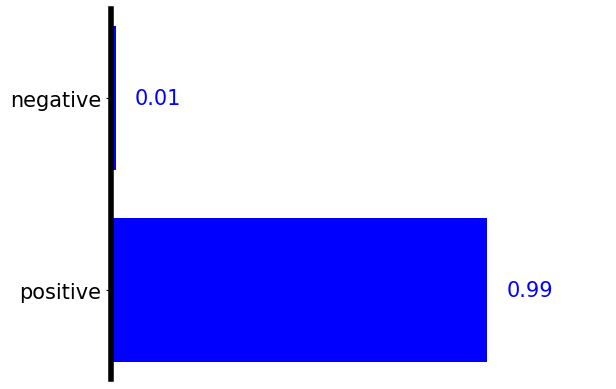

In [ ]:
# example tweet 4
my_tweet_4 = "MERRY CHRISTMAS AND HAPPY NEW YEAR GUYS!!!"

x4 = utils.text2tensor(my_tweet_4).to(device)
print('TENSOR:', x4)

x4 = x4.view(1,-1)

net.eval()
with torch.no_grad():
    scores = net(x4)
    p = F.softmax(scores, dim=1).cpu()

print('TWEET:', my_tweet_4)
utils.show_prob(p)

TENSOR: tensor([ 30, 392,  10, 112,   0, 661,   0,   0, 106,   2, 148],
       device='cuda:0')
TWEET: Just finished my last final. I'm FREEEE. Mombasa, here I come


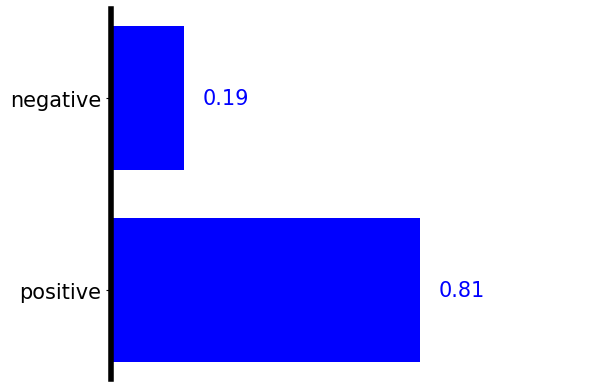

In [ ]:
# example tweet 5
my_tweet_5 = "Just finished my last final. I'm FREEEE. Mombasa, here I come"

x5 = utils.text2tensor(my_tweet_5).to(device)
print('TENSOR:', x5)

x5 = x5.view(1,-1)

net.eval()
with torch.no_grad():
    scores = net(x5)
    p = F.softmax(scores, dim=1).cpu()

print('TWEET:', my_tweet_5)
utils.show_prob(p)